B = 0: LOOCV score = -0.6659 | Approximate MSE = 1.0010
B = 1: LOOCV score = -0.7241 | Approximate MSE = 0.5020
B = 2: LOOCV score = -0.8822 | Approximate MSE = 0.2540
B = 3: LOOCV score = -0.9729 | Approximate MSE = 0.1330
B = 4: LOOCV score = -0.9787 | Approximate MSE = 0.0785
B = 5: LOOCV score = -0.9754 | Approximate MSE = 0.0633
B = 6: LOOCV score = -0.9285 | Approximate MSE = 0.0796
B = 7: LOOCV score = -0.7853 | Approximate MSE = 0.1358

Best resolution level (B) by LOOCV = 4


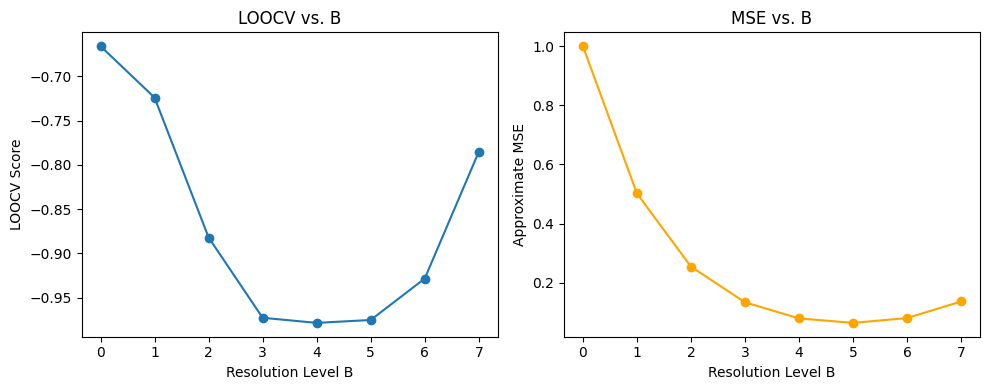

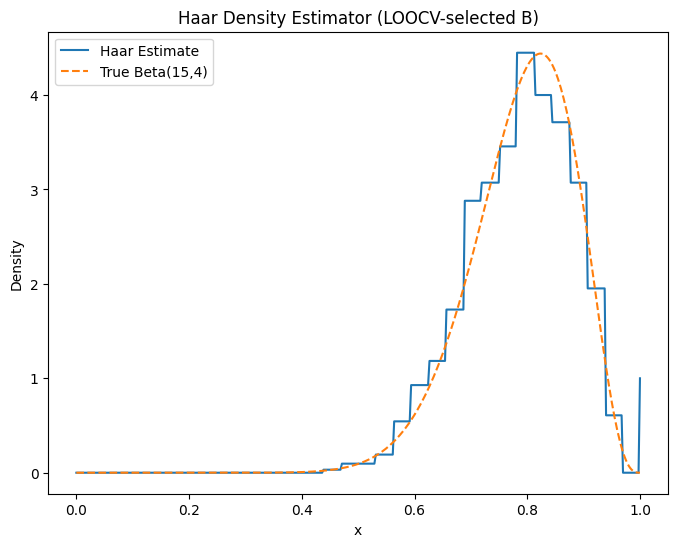

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def psi(u):
  # mother wavelet
    u = np.asarray(u)
    return np.where((u >= 0) & (u < 0.5), 1.0,
                    np.where((u >= 0.5) & (u < 1.0), -1.0, 0.0))

def psi_jk(x, j, k):
    return 2**(j / 2) * psi(2**j * x - k)

def approximate_mse(B, n, r=1.0):
  # MSE for b levels
    bias_term = 2**(-B * r)
    variance_term = 2**B / n
    return bias_term + variance_term

def compute_loocv_score(data, B, eps=1e-6):
    n = len(data)

    # sum for wavelets
    S = {}
    for j in range(B + 1):
        for k in range(2 ** j):
            psi_vals = psi_jk(data, j, k)
            S[(j, k)] = psi_vals.sum()

    # LOOCV est.
    fhat = np.zeros(n)
    for i in range(n):
        x_i = data[i]
        f_val = 1.0  # father wavelet:flat 1 on [0,1].
        for j in range(B + 1):
            for k in range(2 ** j):
                psi_val = psi_jk(x_i, j, k)
                beta_hat_loocv = (S[(j, k)] - psi_val) / (n - 1)
                f_val += beta_hat_loocv * psi_val
        fhat[i] = f_val

    # to prevent log(0):
    errors = -np.log(np.maximum(fhat, eps))
    return errors.mean()

def haar_density_estimator(data, B, x_grid):
    n = len(data)
    coeffs = {}
    for j in range(B + 1):
        for k in range(2 ** j):
            psi_vals = psi_jk(data, j, k)
            coeffs[(j, k)] = psi_vals.mean()

    f_est = np.ones_like(x_grid)  # flat father wavelet to start
    for j in range(B + 1):
        for k in range(2 ** j):
            f_est += coeffs[(j, k)] * psi_jk(x_grid, j, k)
    return f_est

if __name__ == "__main__":
    n = 1000
    data = np.random.beta(15, 4, n)  # 100 samples, Beta(15,4)

    # varying resolution
    candidate_Bs = range(0, 8)  # for B from 0 to 7.
    cv_scores = []
    approx_mse_values = []

    # LOOCV and MSEs
    for B in candidate_Bs:
        score = compute_loocv_score(data, B)
        cv_scores.append(score)
        mse_approx = approximate_mse(B, n, r=1.0)
        approx_mse_values.append(mse_approx)
        print(f"B = {B}: LOOCV score = {score:.4f} | Approximate MSE = {mse_approx:.4f}")

    # pick b with lowest MSE
    best_B = candidate_Bs[np.argmin(cv_scores)]
    print(f"\nBest resolution level (B) by LOOCV = {best_B}")

    # plot LOOCV and approximate MSE vs. b
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(candidate_Bs, cv_scores, marker="o")
    plt.xlabel("Resolution Level B")
    plt.ylabel("LOOCV Score")
    plt.title("LOOCV vs. B")

    plt.subplot(1, 2, 2)
    plt.plot(candidate_Bs, approx_mse_values, marker="o", color="orange")
    plt.xlabel("Resolution Level B")
    plt.ylabel("Approximate MSE")
    plt.title("MSE vs. B")

    plt.tight_layout()
    plt.show()

    # final density estimates
    x_grid = np.linspace(0, 1, 400)
    f_hat = haar_density_estimator(data, best_B, x_grid)
    f_true = beta.pdf(x_grid, 15, 4)  # actual density

    # estimated and actual
    plt.figure(figsize=(8, 6))
    plt.plot(x_grid, f_hat, label="Haar Estimate")
    plt.plot(x_grid, f_true, linestyle="--", label="True Beta(15,4)")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.title("Haar Density Estimator (LOOCV-selected B)")
    plt.legend()
    plt.show()